## PINN for solving Simple Damped Harmonic Oscillation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
memory = 1024

if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit= memory)]
        )
        print(f"GPU memory limiting to {memory} MB")
    except RuntimeError as e:
        print(e)

GPU memory limiting to 1024 MB


### initial condition
* This condition begins when the spring is pulled down and then released upwards.

In [3]:
def solusi_eksak(d, w0, t):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = tf.cos(phi+w*t)
    exp = tf.exp(-d*t)
    u = exp*2*A*cos
    return u

In [4]:
# noted that m = 1

delta = 2
w0 = 20
mu = 2*delta
k = w0**2
t_Test = tf.reshape(np.linspace(0, 1, 300), (-1, 1))


In [5]:
u_eksak = solusi_eksak(delta, w0, t_Test)

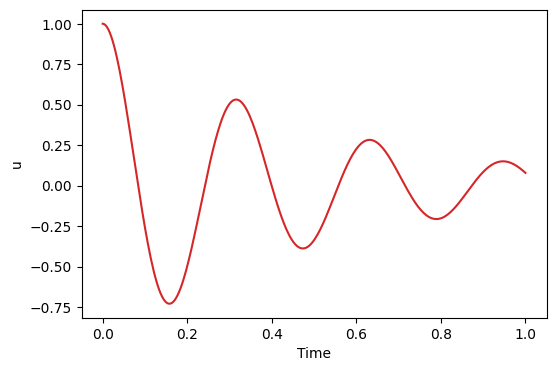

In [7]:
def make_plotter(x, y):
    plt.figure(figsize=(6,4))
    plt.plot(x, y, label='Excact Solution', color='tab:red')
    plt.xlabel("Time")
    plt.ylabel("u")
    plt.show()

make_plotter(t_Test, u_eksak)

In [12]:

class SOLVER(tf.keras.Model):
    def __init__(self, N_input, N_output, N_hidden, activation = 'tanh'):
        super().__init__()

        self.input_layer = tf.keras.layers.Dense(N_hidden, activation=activation, input_shape=(N_input,))
        self.hidden_layer = tf.keras.layers.Dense(N_hidden, activation=activation)
        self.output_layer = tf.keras.layers.Dense(N_output)

    def call(self, x):                  
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.hidden_layer(x)  
        x = self.output_layer(x)
        return x

np.random.seed(42)
pinn = SOLVER(1, 1, 32)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Variabel t_boundary dan t_physics sebagai tensor dan gradients aktif
t_boundary = tf.Variable([[0.0]], dtype=tf.float32)
t_physics = tf.Variable(tf.linspace(0.0, 1.0, 30)[:, tf.newaxis], dtype=tf.float32)
history_loss = []

lambda1, lambda2 = 1e-1, 1e-3

for i in range(20_001):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([t_boundary, t_physics])

        # Boundary condition
        u_boundary = pinn(t_boundary)
        loss1 = tf.abs(tf.squeeze(u_boundary) - 1.0)  # Target harus 1

        dudt_boundary = tape.gradient(u_boundary, t_boundary)
        loss2 = tf.abs(tf.squeeze(dudt_boundary) - 0.0)  # Target turunan harus 0

        # Physics-informed loss
        u_physics = pinn(t_physics)
        dudt_physics = tape.gradient(u_physics, t_physics)
        d2udt2_physics = tape.gradient(dudt_physics, t_physics)

        physics_residual = d2udt2_physics + mu * dudt_physics + k * u_physics
        loss3 = tf.reduce_mean(tf.square(physics_residual))

        # Total loss
        loss = loss1 + lambda1 * loss2 + lambda2 * loss3
        history_loss.append(loss.numpy())

    # Backpropagation
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    del tape  # Buat hemat memori

    if i % 1000 == 0:
        print(f"Iter {i}: Loss = {loss.numpy():.4f}")

        


Iter 0: Loss = 2.365965
Iter 1000: Loss = 0.993892
Iter 2000: Loss = 0.993510
Iter 3000: Loss = 0.989654
Iter 4000: Loss = 0.983348
Iter 5000: Loss = 0.880088
Iter 6000: Loss = 0.867961
Iter 7000: Loss = 0.835795
Iter 8000: Loss = 0.782253
Iter 9000: Loss = 0.568336
Iter 10000: Loss = 0.417618
Iter 11000: Loss = 0.367635
Iter 12000: Loss = 0.309107
Iter 13000: Loss = 0.157003
Iter 14000: Loss = 0.132641
Iter 15000: Loss = 0.132432
Iter 16000: Loss = 0.121186
Iter 17000: Loss = 0.101897
Iter 18000: Loss = 0.104049
Iter 19000: Loss = 0.098326


In [ ]:
%%skip%%
# improvment 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Variabel t_boundary dan t_physics sebagai tensor dan gradients aktif
t_boundary = tf.Variable([[0.0]], dtype=tf.float32)
t_physics = tf.Variable(tf.linspace(0.0, 1.0, 30)[:, tf.newaxis], dtype=tf.float32)
history_loss = []

lambda1, lambda2 = 1e-1, 1e-3

for i in range(20_000):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t_boundary, t_physics])

        # --- Boundary Loss ---
        with tf.GradientTape() as tape_b:
            tape_b.watch(t_boundary)
            u_boundary = pinn(t_boundary)
        dudt_boundary = tape_b.gradient(u_boundary, t_boundary)

        loss1 = tf.abs(tf.squeeze(u_boundary) - 1.0)
        loss2 = tf.abs(tf.squeeze(dudt_boundary) - 0.0)

        # --- Physics-Informed Loss ---
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(t_physics)
            u_physics = pinn(t_physics)

        dudt_physics = tape1.gradient(u_physics, t_physics)
        d2udt2_physics = tape2.gradient(dudt_physics, t_physics)

        physics_residual = d2udt2_physics + mu * dudt_physics + k * u_physics
        loss3 = tf.reduce_mean(tf.square(physics_residual))

        # Total Loss
        loss = loss1 + lambda1 * loss2 + lambda2 * loss3
        history_loss.append(loss.numpy())

    gradients = tape2.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    del tape1, tape2

    if i % 1000 == 0:
        print(f"Iter {i}: Loss = {loss.numpy():.6f}")
        


UsageError: Cell magic `%%skip` not found.


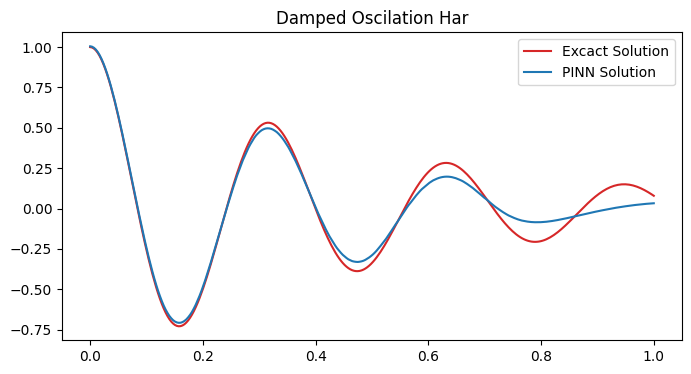

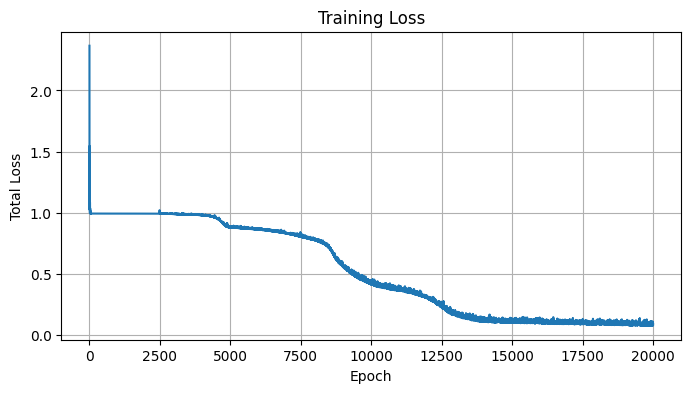

In [11]:
u = pinn(t_Test)
u_detached = tf.stop_gradient(u)
plt.figure(figsize=(8,4))
plt.plot(t_Test[:,0], u_eksak[:,0], label='Excact Solution', color='tab:red')
plt.plot(t_Test[:,0], u_detached[:,0], label='PINN Solution', color='tab:blue')
plt.title('Damped Oscilation Har')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history_loss)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()